# Loan default Prediction using ML models #

#### Importing libraries ####

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import train_test_split,KFold,cross_val_score

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from catboost import CatBoostClassifier

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

#### Data pre-processing ####

In [24]:
df = pd.read_csv("data.csv")

df = df.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],axis = 1)

## Credit grade mapping based on description, 4 being the best and 0 being the worst and -1 means no info
credit_mapping = {'A': 4, 'B':4, 'C': 4, 'D':4, 'E':3, 'F':3, 'G':3, 'H':2,'I':2,'J':1, 'K':1,'L':0, 'M':0}

## Employment mapping
employment_mapping = {'Self employed': 1, 'Salaried': 2}

def credit_grade(df):
    new_df = []
    for record in df:
        num_words = record.split("-")
        if len(num_words) == 1:
            new_df.append(-1)
        else:
            new_df.append(credit_mapping.get(record[0], -1))
    return new_df

df.loc[:,'credit_grade'] = credit_grade(df['PERFORM_CNS.SCORE.DESCRIPTION'])
df.loc[:,'employment'] = df['Employment.Type'].map(employment_mapping).fillna(0)

df = df.drop(['Employment.Type','PERFORM_CNS.SCORE.DESCRIPTION'], axis = 1)

## Calculate age based on date of birth and disbursal date

def age(value):
    yr = int(value.split('-')[2])
    if yr >=0 and yr<=19:
        return yr+2000
    else:
         return yr+1900

df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age)
df['age']=df['DisbursalDate']-df['Date.of.Birth']
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)

## EDA (Exploratory Data Analysis) ##

In [25]:
df.head()

,disbursed_amount,asset_cost,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,...,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,credit_grade,employment,age
0,50578,58400,89.55,45,1,0,0,0,0,0,...,0,0,0,0yrs 0mon,0yrs 0mon,0,0,-1,2.0,34
1,47145,65550,73.23,45,1,0,0,0,0,598,...,0,0,1,1yrs 11mon,1yrs 11mon,0,1,2,1.0,33
2,53278,61360,89.63,45,1,0,0,0,0,0,...,0,0,0,0yrs 0mon,0yrs 0mon,0,0,-1,1.0,33
3,57513,66113,88.48,45,1,0,0,0,0,305,...,0,0,0,0yrs 8mon,1yrs 3mon,1,1,0,1.0,25
4,52378,60300,88.39,45,1,0,0,0,0,0,...,0,0,0,0yrs 0mon,0yrs 0mon,1,1,-1,1.0,41


In [26]:
df.nunique()

disbursed_amount                       24565
asset_cost                             46252
ltv                                     6579
manufacturer_id                           11
Aadhar_flag                                2
PAN_flag                                   2
VoterID_flag                               2
Driving_flag                               2
Passport_flag                              2
PERFORM_CNS.SCORE                        573
PRI.NO.OF.ACCTS                          108
PRI.ACTIVE.ACCTS                          40
PRI.OVERDUE.ACCTS                         22
PRI.CURRENT.BALANCE                    71341
PRI.SANCTIONED.AMOUNT                  44390
PRI.DISBURSED.AMOUNT                   47909
SEC.NO.OF.ACCTS                           37
SEC.ACTIVE.ACCTS                          23
SEC.OVERDUE.ACCTS                          9
SEC.CURRENT.BALANCE                     3246
SEC.SANCTIONED.AMOUNT                   2223
SEC.DISBURSED.AMOUNT                    2553
PRIMARY.IN

In [27]:
percentages = df['loan_default'].value_counts(normalize=True) * 100
print(percentages)

loan_default
0    78.292888
1    21.707112
Name: proportion, dtype: float64


loan_default
0    182543
1     50611
Name: count, dtype: int64


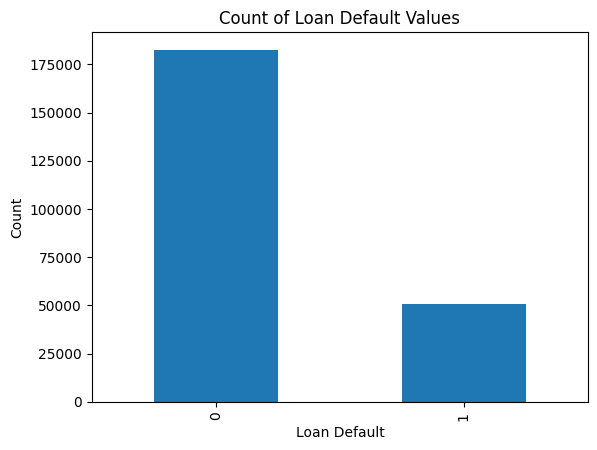

In [28]:
## Target variable distribution

value_counts = df['loan_default'].value_counts()
print(value_counts)

value_counts.plot(kind='bar')
plt.xlabel('Loan Default')
plt.ylabel('Count')
plt.title('Count of Loan Default Values')
plt.show()

In [29]:
df.describe()

,disbursed_amount,asset_cost,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,...,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,credit_grade,employment,age
count,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.00000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,...,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000
mean,54356.993528,7.586507e+04,74.746530,69.028054,0.84032,0.075577,0.144943,0.023242,0.002127,289.462994,...,7.179998e+03,1.310548e+04,3.232684e+02,0.381833,0.097481,0.206615,0.217071,0.707078,1.386856,34.100946
std,12971.314171,1.894478e+04,11.456636,22.141304,0.36631,0.264320,0.352044,0.150672,0.046074,338.374779,...,1.825925e+05,1.513679e+05,1.555369e+04,0.955107,0.384439,0.706498,0.412252,2.123337,0.550378,9.805992
min,13320.000000,3.700000e+04,10.030000,45.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,18.000000
25%,47145.000000,6.571700e+04,68.880000,48.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,26.000000
50%,53803.000000,7.094600e+04,76.800000,86.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,32.000000
75%,60413.000000,7.920175e+04,83.670000,86.000000,1.00000,0.000000,0.000000,0.000000,0.000000,678.000000,...,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,41.000000
max,990572.000000,1.628992e+06,95.000000,156.000000,1.00000,1.000000,1.000000,1.000000,1.000000,890.000000,...,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,36.000000,1.000000,4.000000,2.000000,69.000000


In [30]:
print(df['Driving_flag'].value_counts())
print(df['Aadhar_flag'].value_counts())
print(df['PAN_flag'].value_counts())
print(df['VoterID_flag'].value_counts())
print(df['Passport_flag'].value_counts())


Driving_flag
0    227735
1      5419
Name: count, dtype: int64
Aadhar_flag
1    195924
0     37230
Name: count, dtype: int64
PAN_flag
0    215533
1     17621
Name: count, dtype: int64
VoterID_flag
0    199360
1     33794
Name: count, dtype: int64
Passport_flag
0    232658
1       496
Name: count, dtype: int64


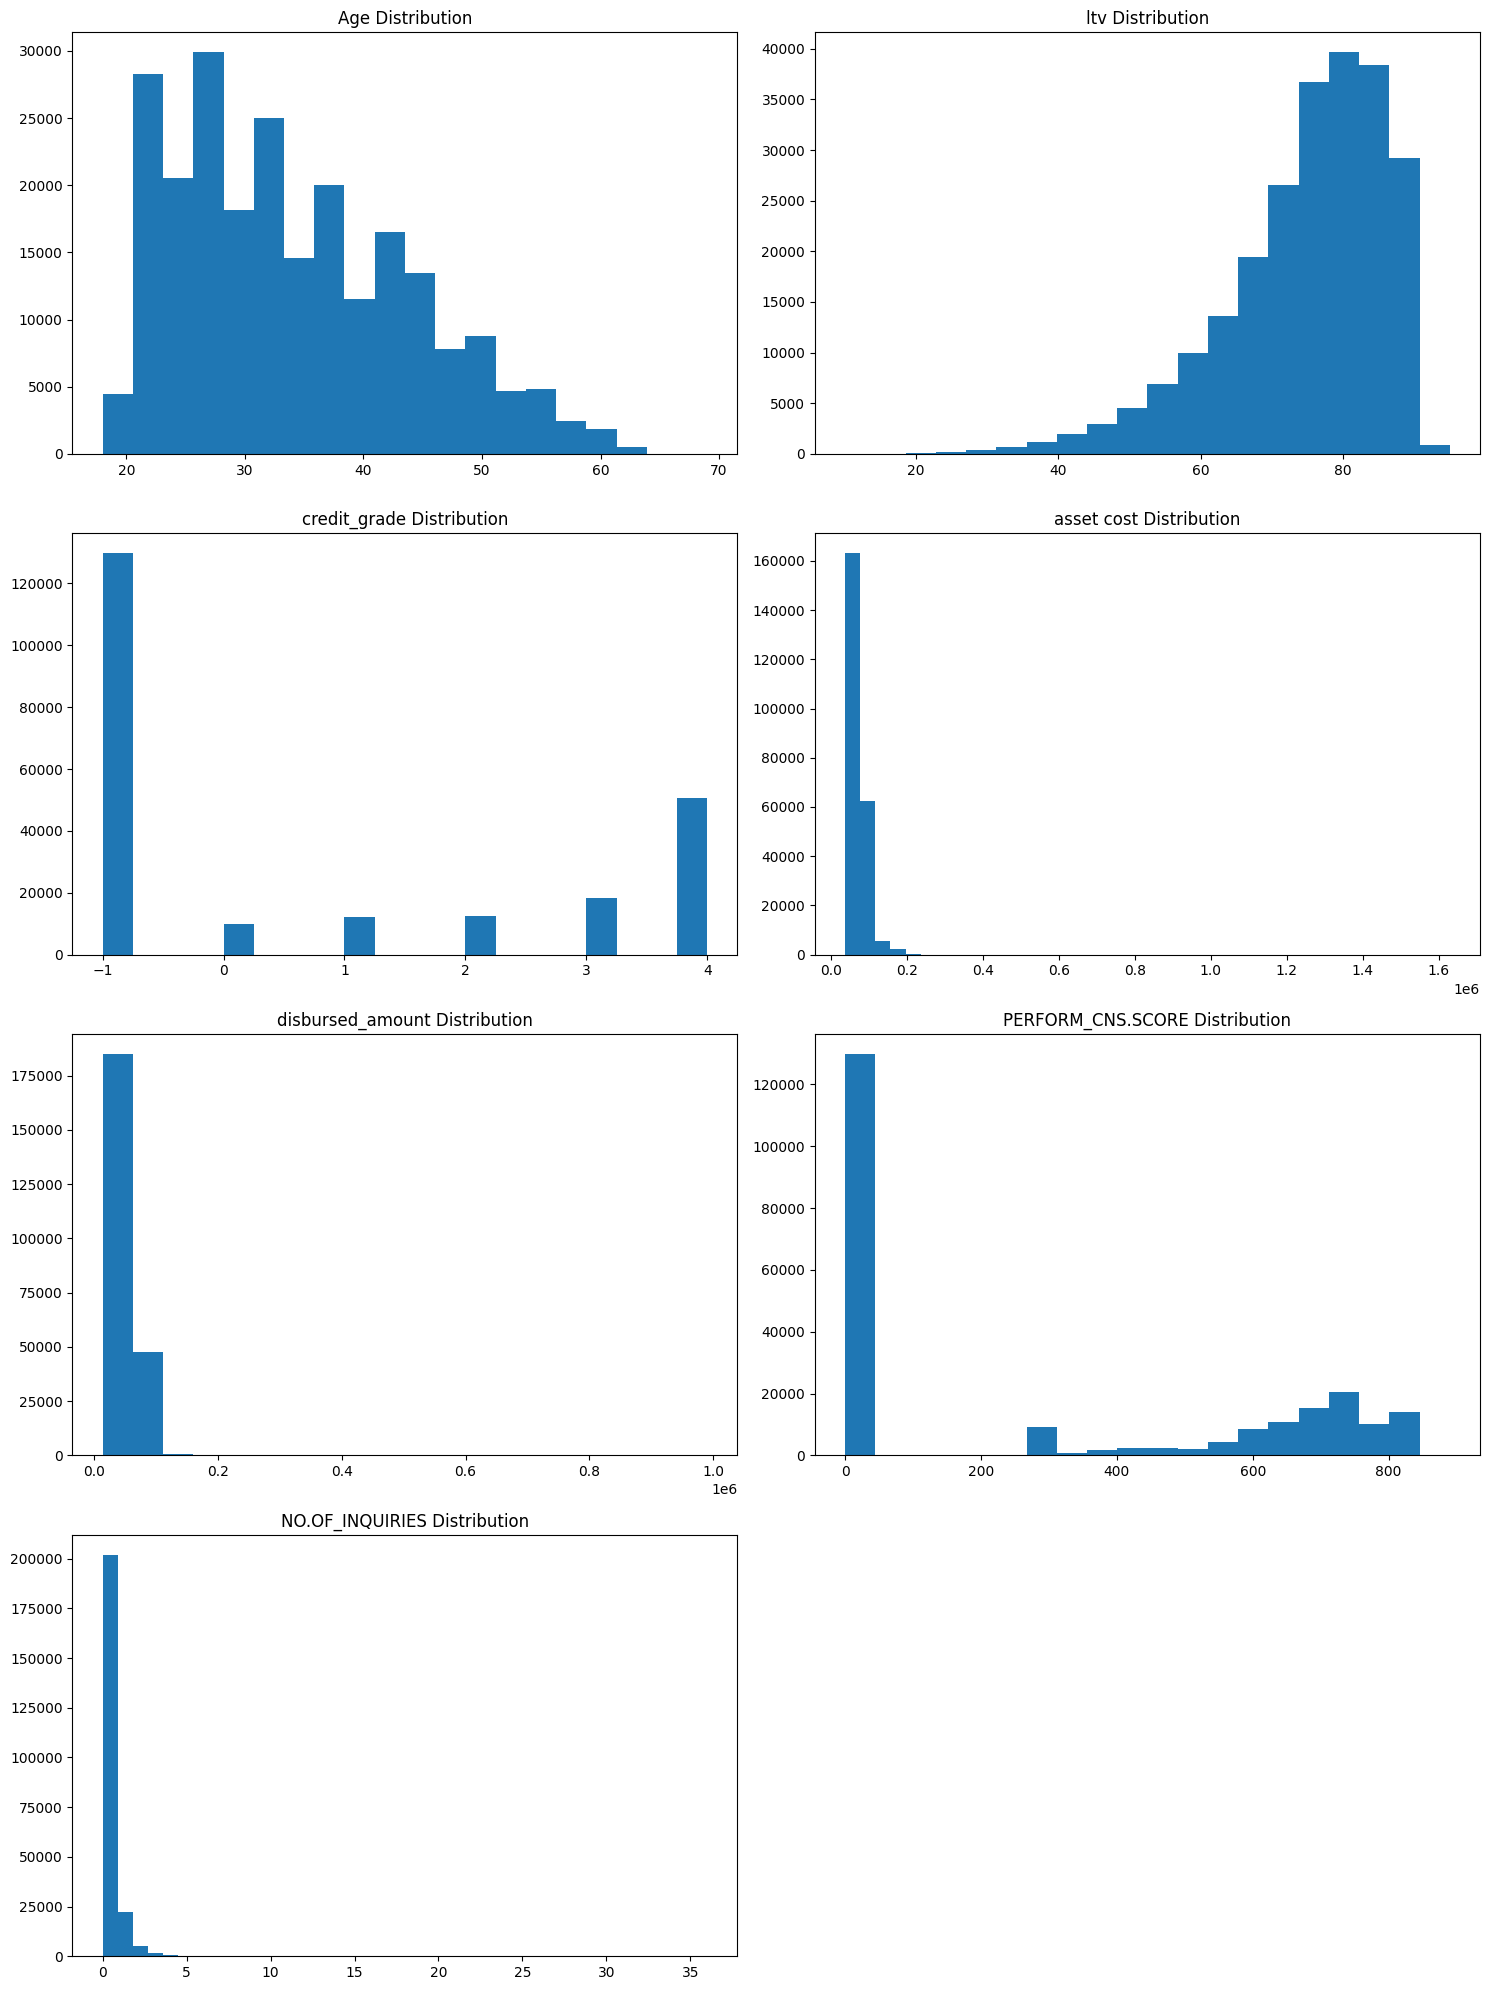

In [31]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Plotting each distribution
axs[0, 0].hist(df['age'], bins=20)
axs[0, 0].set_title("Age Distribution")

axs[0, 1].hist(df['ltv'], bins=20)
axs[0, 1].set_title("ltv Distribution")

axs[1, 0].hist(df['credit_grade'], bins=20)
axs[1, 0].set_title("credit_grade Distribution")

axs[1, 1].hist(df['asset_cost'], bins=40)
axs[1, 1].set_title("asset cost Distribution")

axs[2, 0].hist(df['disbursed_amount'], bins=20)
axs[2, 0].set_title("disbursed_amount Distribution")

axs[2, 1].hist(df['PERFORM_CNS.SCORE'], bins=20)
axs[2, 1].set_title("PERFORM_CNS.SCORE Distribution")

axs[3, 0].hist(df['NO.OF_INQUIRIES'], bins=40)
axs[3, 0].set_title("NO.OF_INQUIRIES Distribution")

# Removing the last empty subplot
fig.delaxes(axs[3, 1])

# Adjust layout
plt.tight_layout()
plt.show()

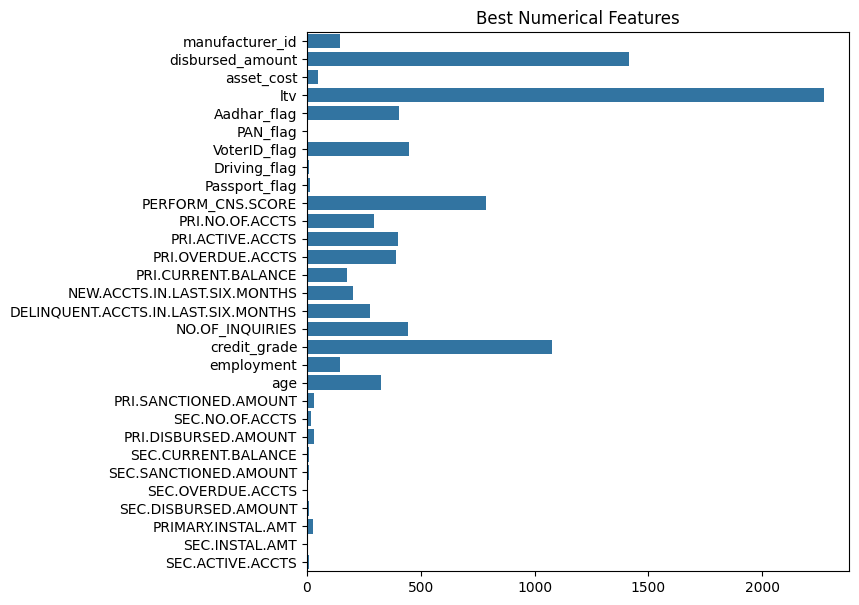

In [32]:
numerical = ['manufacturer_id','disbursed_amount','asset_cost','ltv','Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag',
       'Passport_flag', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'credit_grade', 'employment', 'age', 'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','SEC.ACTIVE.ACCTS']

feature_model = SelectKBest(score_func=f_classif,k = 10)
k_scores = feature_model.fit(df[numerical], df['loan_default'])
plt.figure(figsize=(7,7))
sns.barplot(x=k_scores.scores_,y=numerical)
plt.title('Best Numerical Features')
plt.show()

<Axes: >

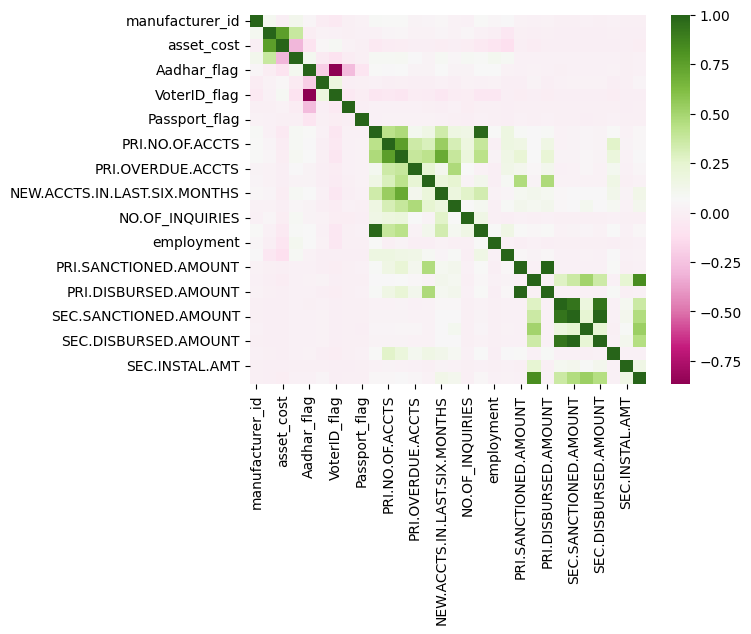

In [33]:
## Visualizing correlations between numerical variables
sns.heatmap(df[numerical].corr(),cmap="PiYG")

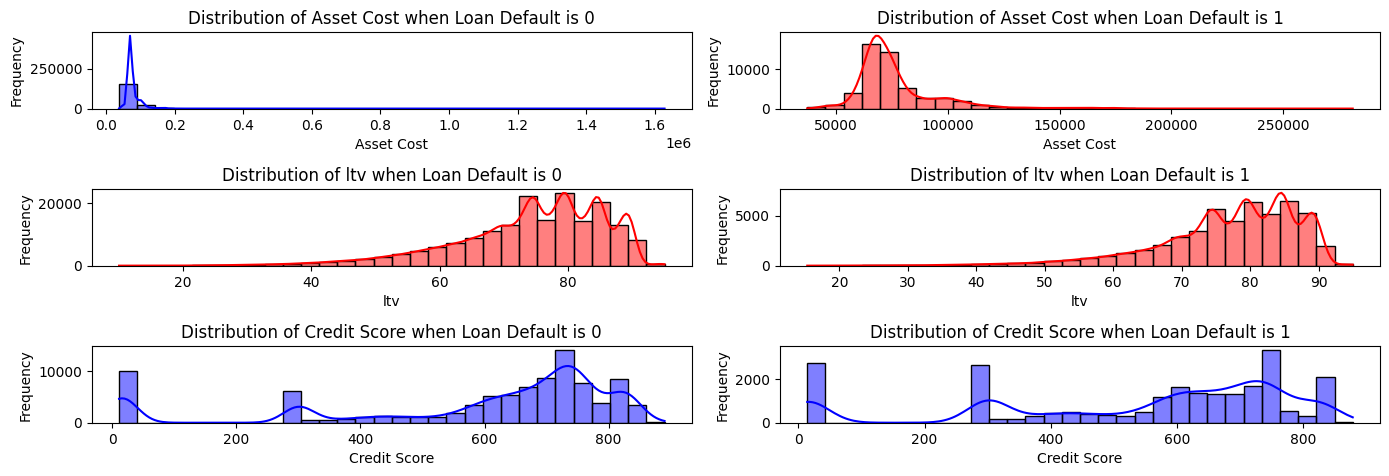

In [34]:
## Distribution of Asset cost against target variable and KDE(kernel density estimate curve)

plt.figure(figsize=(14, 6))

plt.subplot(4, 2, 1)
sns.histplot(df[df['loan_default'] == 0]['asset_cost'],bins = 30, kde=True, color='blue')
plt.title('Distribution of Asset Cost when Loan Default is 0')
plt.xlabel('Asset Cost')
plt.ylabel('Frequency')

plt.subplot(4, 2, 2)
sns.histplot(df[df['loan_default'] == 1]['asset_cost'], bins=30, kde=True, color='red')
plt.title('Distribution of Asset Cost when Loan Default is 1')
plt.xlabel('Asset Cost')
plt.ylabel('Frequency')

plt.subplot(4, 2, 3)
sns.histplot(df[df['loan_default'] == 0]['ltv'], bins=30, kde=True, color='red')
plt.title('Distribution of ltv when Loan Default is 0')
plt.xlabel('ltv')
plt.ylabel('Frequency')

plt.subplot(4, 2, 4)
sns.histplot(df[df['loan_default'] == 1]['ltv'], bins=30, kde=True, color='red')
plt.title('Distribution of ltv when Loan Default is 1')
plt.xlabel('ltv')
plt.ylabel('Frequency')

plt.subplot(4, 2, 5)
sns.histplot(df[(df['loan_default'] == 0) & (df['PERFORM_CNS.SCORE'] != 0)]['PERFORM_CNS.SCORE'], bins=30, kde=True, color='blue')
plt.title('Distribution of Credit Score when Loan Default is 0')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')

plt.subplot(4, 2, 6)
sns.histplot(df[(df['loan_default'] == 1) & (df['PERFORM_CNS.SCORE'] != 0)]['PERFORM_CNS.SCORE'], bins=30, kde=True, color='blue')
plt.title('Distribution of Credit Score when Loan Default is 1')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


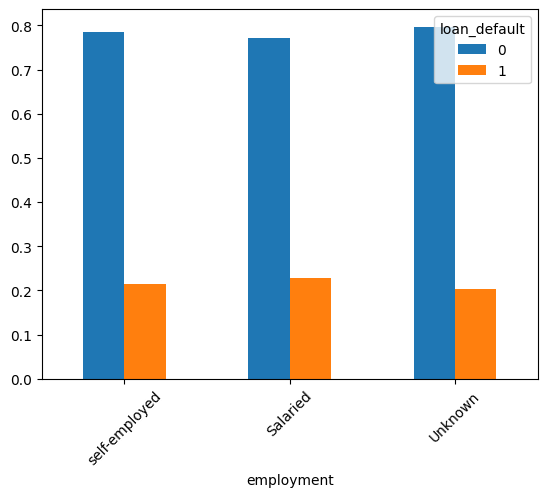

In [35]:
## Distribution of Employment type against target variable

mapping = {0: "self-employed", 1:"Salaried", 2:"Unknown"}
ax = df.groupby('employment')['loan_default'].value_counts(normalize = True).unstack().plot.bar()

tick_labels = [mapping.get(item, str(item)) for item in ax.get_xticks()]
ax.set_xticklabels(tick_labels, rotation=45)
plt.show()

## We can see that Self-Employed and Unknown employment types default on a slightly higher rate


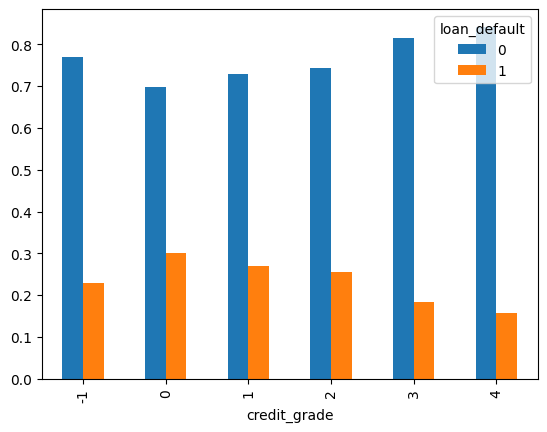

In [36]:
## Distribution of Credit Grade against target variable

ax = df.groupby('credit_grade')['loan_default'].value_counts(normalize = True).unstack().plot.bar()

plt.show()

## A lower credit grade means higher risk and we can see higher risk credit grades default on a higher rate
## -1 refers to no data


In [37]:
#Dropping features with low k_score

df=df.drop(['manufacturer_id','PAN_flag','Driving_flag','Passport_flag','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH','SEC.NO.OF.ACCTS', 'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','SEC.ACTIVE.ACCTS'],axis=1)

In [38]:
## SMOTE library to fix data imbalance, Robust scaler for better normalization and scaling

# Note: It's Crucial to only apply SMOTE after the train-test split and apply it only on the train-set. If you apply SMOTE on the whole dataset before split then test data will leak into training data.

y = df.loan_default
X = df.drop("loan_default", axis = 1)

scaler = RobustScaler()
X_tf = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tf, y, test_size=0.20, random_state=42)

from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train,y_train = smote.fit_resample(X_train,y_train)

In [55]:
print(X_test[0])

[ 1.86546578  2.37060383  0.1954023  -1.          1.          0.72713864
  1.          3.          1.         36.57220802  2.          1.
  0.          0.5         0.          1.2       ]


# Models #

In [39]:
## Function to call different models

def train_model(model, model_name):
    print(model_name)
    
    model = model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    #Model accuracy
    acc = accuracy_score(y_test, pred)
    print('accuracy_score',acc)
    print('precision_score',precision_score(y_test, pred))
    print('recall_score',recall_score(y_test, pred))
    print('f1_score',f1_score(y_test, pred))
    
    # Confusion matrix
    print('\nconfusion_matrix')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print(f'\n{classification_report(y_test,pred)}')

### Random Forest Classifier ###

In [40]:
rfc = RandomForestClassifier(n_estimators = 1500, n_jobs=-1, max_depth=15, 
                             min_samples_split=5, min_samples_leaf=3)
train_model(rfc, 'Random Forest Classifier')
import joblib
joblib.dump(rfc, 'random_forest_model.joblib')

Random Forest Classifier
accuracy_score 0.627029229482533
precision_score 0.29112316749393974
recall_score 0.49675004924167815
f1_score 0.3671033478893741

confusion_matrix
       0      1
0  24195  12282
1   5110   5044

              precision    recall  f1-score   support

           0       0.83      0.66      0.74     36477
           1       0.29      0.50      0.37     10154

    accuracy                           0.63     46631
   macro avg       0.56      0.58      0.55     46631
weighted avg       0.71      0.63      0.66     46631



['random_forest_model.joblib']

In [41]:
lr=LogisticRegression()
train_model(lr, "Logistic Regression")

Logistic Regression
accuracy_score 0.5636379232699277
precision_score 0.28043422072887053
recall_score 0.6411266495962182
f1_score 0.3901941980340446

confusion_matrix
       0      1
0  19773  16704
1   3644   6510

              precision    recall  f1-score   support

           0       0.84      0.54      0.66     36477
           1       0.28      0.64      0.39     10154

    accuracy                           0.56     46631
   macro avg       0.56      0.59      0.53     46631
weighted avg       0.72      0.56      0.60     46631



### Gradient boosting model (XGB Classifier) ###

In [42]:
xgb4 = XGBClassifier(
 learning_rate =0.001,
 n_estimators=5000,
 max_depth=9,
 objective= 'binary:logistic',
 seed=27)

train_model(xgb4, "XGB4")

XGB4
accuracy_score 0.6738435804507731
precision_score 0.297036858588292
recall_score 0.36428993500098483
f1_score 0.32724377405228466

confusion_matrix
       0     1
0  27723  8754
1   6455  3699

              precision    recall  f1-score   support

           0       0.81      0.76      0.78     36477
           1       0.30      0.36      0.33     10154

    accuracy                           0.67     46631
   macro avg       0.55      0.56      0.56     46631
weighted avg       0.70      0.67      0.69     46631



### Gradient boosting model (XGBRF Classifier) ###

In [43]:
xgbr = XGBRFClassifier(n_estimators = 2000, max_depth = 10, learning_rate=0.01)
train_model(xgbr, 'XGBRFClassifier')

XGBRFClassifier
accuracy_score 0.5961699298749759
precision_score 0.28212725355295537
recall_score 0.5532794957652156
f1_score 0.3736987394818239

confusion_matrix
       0      1
0  22182  14295
1   4536   5618

              precision    recall  f1-score   support

           0       0.83      0.61      0.70     36477
           1       0.28      0.55      0.37     10154

    accuracy                           0.60     46631
   macro avg       0.56      0.58      0.54     46631
weighted avg       0.71      0.60      0.63     46631



In [44]:
knn = KNeighborsClassifier(weights='distance', algorithm='auto', n_neighbors=15, n_jobs=4)
train_model(knn, 'K Nearest Neighbour')

K Nearest Neighbour
accuracy_score 0.566940447341897
precision_score 0.2545952287837309
recall_score 0.5129013196769746
f1_score 0.340280953936622

confusion_matrix
       0      1
0  21229  15248
1   4946   5208

              precision    recall  f1-score   support

           0       0.81      0.58      0.68     36477
           1       0.25      0.51      0.34     10154

    accuracy                           0.57     46631
   macro avg       0.53      0.55      0.51     46631
weighted avg       0.69      0.57      0.60     46631



In [45]:
dtc = DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=25, min_samples_split=4,
                            min_samples_leaf=2)
train_model(dtc, 'Decision Tree Classifier')

Decision Tree Classifier
accuracy_score 0.6074285346657803
precision_score 0.2669525443110349
recall_score 0.45981879062438447
f1_score 0.3377948198524092

confusion_matrix
       0      1
0  23656  12821
1   5485   4669

              precision    recall  f1-score   support

           0       0.81      0.65      0.72     36477
           1       0.27      0.46      0.34     10154

    accuracy                           0.61     46631
   macro avg       0.54      0.55      0.53     46631
weighted avg       0.69      0.61      0.64     46631



In [46]:
bnb = BernoulliNB()
train_model(bnb, 'Bernolli Naive Bayes')

Bernolli Naive Bayes
accuracy_score 0.5572687697025583
precision_score 0.2689512399242391
recall_score 0.6013393736458539
f1_score 0.3716711811790486

confusion_matrix
       0      1
0  19880  16597
1   4048   6106

              precision    recall  f1-score   support

           0       0.83      0.55      0.66     36477
           1       0.27      0.60      0.37     10154

    accuracy                           0.56     46631
   macro avg       0.55      0.57      0.51     46631
weighted avg       0.71      0.56      0.60     46631



In [47]:
lgbm = LGBMClassifier(n_estimators=600, n_jobs=-1, max_depth=35, min_child_weight=5, 
                      min_child_samples=5, num_leaves=10, learning_rate=0.01,verbose = 0)
train_model(lgbm, 'LGBMClassifier')

LGBMClassifier
accuracy_score 0.652034054598872
precision_score 0.2893422148209825
recall_score 0.4106755958243057
f1_score 0.3394936090531629

confusion_matrix
       0      1
0  26235  10242
1   5984   4170

              precision    recall  f1-score   support

           0       0.81      0.72      0.76     36477
           1       0.29      0.41      0.34     10154

    accuracy                           0.65     46631
   macro avg       0.55      0.56      0.55     46631
weighted avg       0.70      0.65      0.67     46631



In [48]:
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.01)
train_model(ada, 'AdaBoostClassifier')

AdaBoostClassifier
accuracy_score 0.520705110334327
precision_score 0.26200140504254155
recall_score 0.6611187709277132
f1_score 0.3752795169946333

confusion_matrix
       0      1
0  17568  18909
1   3441   6713

              precision    recall  f1-score   support

           0       0.84      0.48      0.61     36477
           1       0.26      0.66      0.38     10154

    accuracy                           0.52     46631
   macro avg       0.55      0.57      0.49     46631
weighted avg       0.71      0.52      0.56     46631



In [49]:
cat = CatBoostClassifier(verbose = 0)
train_model(cat, "Cat Boost")

Cat Boost
accuracy_score 0.768051296347923
precision_score 0.34913400182315407
recall_score 0.07543825093559188
f1_score 0.12406867508908326

confusion_matrix
       0     1
0  35049  1428
1   9388   766

              precision    recall  f1-score   support

           0       0.79      0.96      0.87     36477
           1       0.35      0.08      0.12     10154

    accuracy                           0.77     46631
   macro avg       0.57      0.52      0.50     46631
weighted avg       0.69      0.77      0.70     46631



In [ ]:
gbc = GradientBoostingClassifier(n_estimators=200, min_samples_split=5, max_depth=4)
train_model(gbc, 'GradientBoostingClassifier')

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes = (200,3), activation = 'relu', solver = 'adam', learning_rate = 'adaptive',
                   max_iter = 100)
train_model(mlp, 'Multi-layer Perceptron Classifier')

Multi-layer Perceptron Classifier
accuracy_score 0.6205099611846197
precision_score 0.29105718085106386
recall_score 0.5173330707110498
f1_score 0.3725267711509822

confusion_matrix
       0      1
0  23682  12795
1   4901   5253

              precision    recall  f1-score   support

           0       0.83      0.65      0.73     36477
           1       0.29      0.52      0.37     10154

    accuracy                           0.62     46631
   macro avg       0.56      0.58      0.55     46631
weighted avg       0.71      0.62      0.65     46631



## Random Forest Classifier Feature significance ##

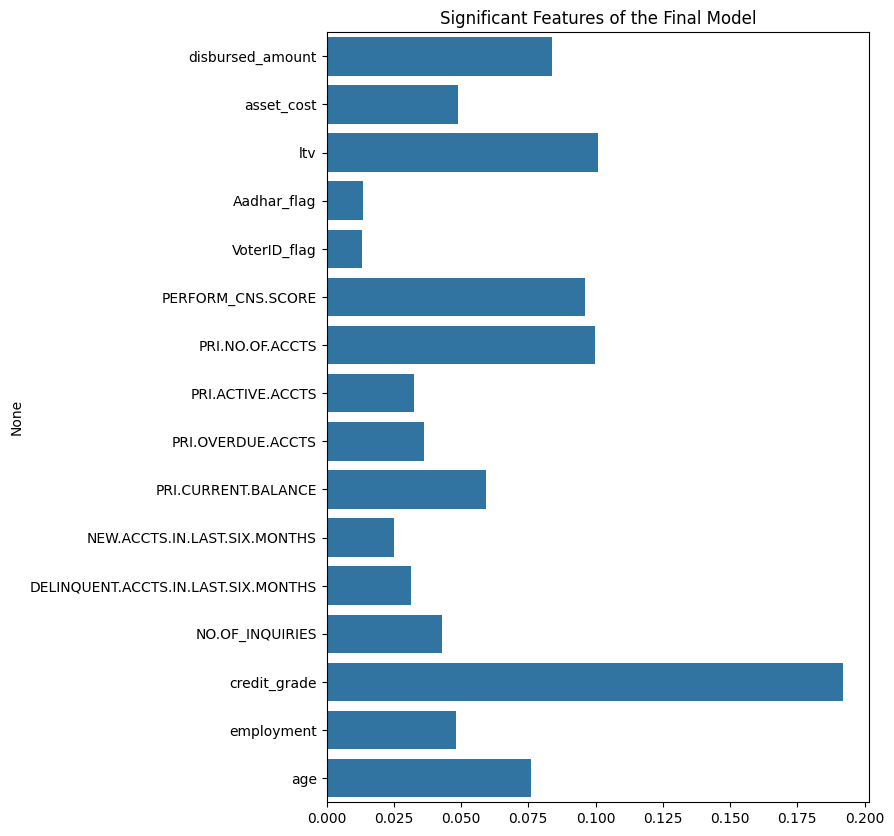

In [51]:
import matplotlib.pyplot as plt

importances = rfc.feature_importances_

plt.figure(figsize=(7,10))
sns.barplot(x=importances,y=X.columns)
plt.title('Significant Features of the Final Model')
plt.show()